# Statistics on Logistic Regression

We will arange data and train LogisticRegression classifier on the data.
The we will try to train again only using quarters from the same cluster (using the quarter classifier).

Our randomly chosen 5 stocks are: 
'SHW', 'MNK', 'BIO', 'KYTH', 'KRO'

# Basic Classifier

In [54]:
from Utilities.orginizers import LearningData, TrainingData
from sklearn.model_selection import KFold, cross_val_score
from itertools import product

from multiprocessing import Pool
import matplotlib.pyplot as plt
import Utilities
import numpy as np
import warnings
import logging
import pandas

%matplotlib inline

ld = LearningData()

In [55]:
stock_names = ('SHW', 'MNK', 'BIO', 'KYTH', 'KRO')
logging.getLogger().setLevel(logging.ERROR)
stocks = [TrainingData(sn).add_history(10).get() for sn in stock_names]

In [3]:
import os
print("Samples per stock:")
print(os.linesep.join(['{} {}'.format(sn, len(data)) for sn, (data, classes) in zip(stock_names, stocks)]))
print("percent of positive classification per stock")
print(os.linesep.join(['{} {}'.format(sn, float(classes.sum())/len(classes)) for sn, (data, classes) in zip(stock_names, stocks)]))
print(stocks[0][0].describe())

Samples per stock:
SHW 7855
MNK 819
BIO 2343
KYTH 718
KRO 3220
percent of positive classification per stock
SHW 0.20038192234245703
MNK 0.1978021978021978
BIO 0.15151515151515152
KYTH 0.201949860724234
KRO 0.20031055900621117
             change        close   ex-divident         high           low  \
count  7.855000e+03  7855.000000  7.855000e+03  7855.000000  7.855000e+03   
mean   2.170977e-17     0.000000  1.447318e-17     0.000000 -1.447318e-16   
std    1.000064e+00     1.000064  1.000064e+00     1.000064  1.000064e+00   
min   -9.826291e-01    -0.711964 -8.285474e-02    -0.708525 -7.122042e-01   
25%   -6.546142e-01    -0.545740 -8.285474e-02    -0.546135 -5.453623e-01   
50%   -2.623907e-01    -0.438244 -8.285474e-02    -0.440260 -4.366827e-01   
75%    3.430775e-01    -0.053682 -8.285474e-02    -0.052620 -5.562959e-02   
max    1.404981e+01     3.669051  2.486545e+01     3.637710  3.656416e+00   

               open   split_ratio        volume  change1_days_before  \
count  7

In [56]:
def run_model(model, inp=stocks):
    matrixes = {sn: [] for sn in stock_names}
    for sn, data in zip(stock_names, inp):
        matrixes[sn] = ConfusionMatrix(data, model)
    return matrixes

def get_best_model(models, accs):
    best_model = (0 , models[0])
    for model, accs in zip(models, accs):
        if sum([cm.accuracy for cm in accs.values()]) > best_model[0]:
            best_model = (sum([cm.accuracy for cm in accs.values()]), model)
    return best_model

def median(lst):
    quotient, remainder = divmod(len(lst), 2)
    if remainder:
        return sorted(lst)[quotient]
    return sum(sorted(lst)[quotient - 1:quotient + 1]) / 2.

def get_best_median_model(models, accs):
    best_model = (0 , models[0])
    for model, accs in zip(models, accs):
        if median(accs.values()) > best_model[0]:
            best_model = (median(accs.values()), model)
    return best_model

## Logistic Regression

This one is pretty powerful and again with data scaled should work excelently. This is expected to bring the best results.

We will look at penalty function (norm), regularization strength (C param), intercept_scaling (the constant added to class calc, should play with this a little), max_iter and tol (tolerance for stopping).

In [57]:
from sklearn.linear_model import LogisticRegression
from Utilities.confusion_matrix import ConfusionMatrix

# create iterables for all options and use itertools product
penaltys = ['l1', 'l2']
Cs = [0.5, 0.7, 1.0, 1.3, 1.5]
intercept_scalings = [0.5, 0.7, 1.0, 1.3, 1.5]
max_iters = [3, 10, 20, 100]
tols = [0.00007, 0.0001, 0.0005]

lmodels = [LogisticRegression(C=c, penalty=p, intercept_scaling=isc, max_iter=mi, tol=t) 
          for c, p, isc, mi, t in product(Cs, penaltys, intercept_scalings, max_iters, tols)]

In [58]:
# For next time

from sklearn.linear_model import LogisticRegression
from Utilities.confusion_matrix import ConfusionMatrix

# create iterables for all options and use itertools product
penaltys = ['l1', 'l2']
Cs = [0.5, 0.7, 1.0, 1.5, 2.5, 5, 10]
intercept_scalings = [0.5, 0.7, 1.0, 1.3, 1.5, 2, 3, 5]

#lmodels = [LogisticRegression(C=c, penalty=p, intercept_scaling=isc, max_iter=mi, tol=t) 
#          for c, p, isc, mi, t in product(Cs, penaltys, intercept_scalings, max_iters, tols)]

from pandas import DataFrame

def get_results(models):
    accuracies = list(map(run_model, models))
    # data should be list of lists and each row should be:
    # criterion, max_depth, min_samples, stock, accuracy
    data = []
    for tmodel, taccs in zip(models, accuracies):
        for tsn, cm in taccs.items():
            data.append((tmodel.C, tmodel.penalty, tmodel.intercept_scaling, tsn, cm.accuracy, cm.true_acc(), cm.false_acc(), cm.TruePos))
    results = DataFrame(data, columns=('C', 'penalty', 'intercept_scaling', 'stock', 'accuracy', 'positive acc', 'negative acc', 'true positive'))
    return results

In [59]:
cresults = get_results([LogisticRegression(C=c) for c in Cs])

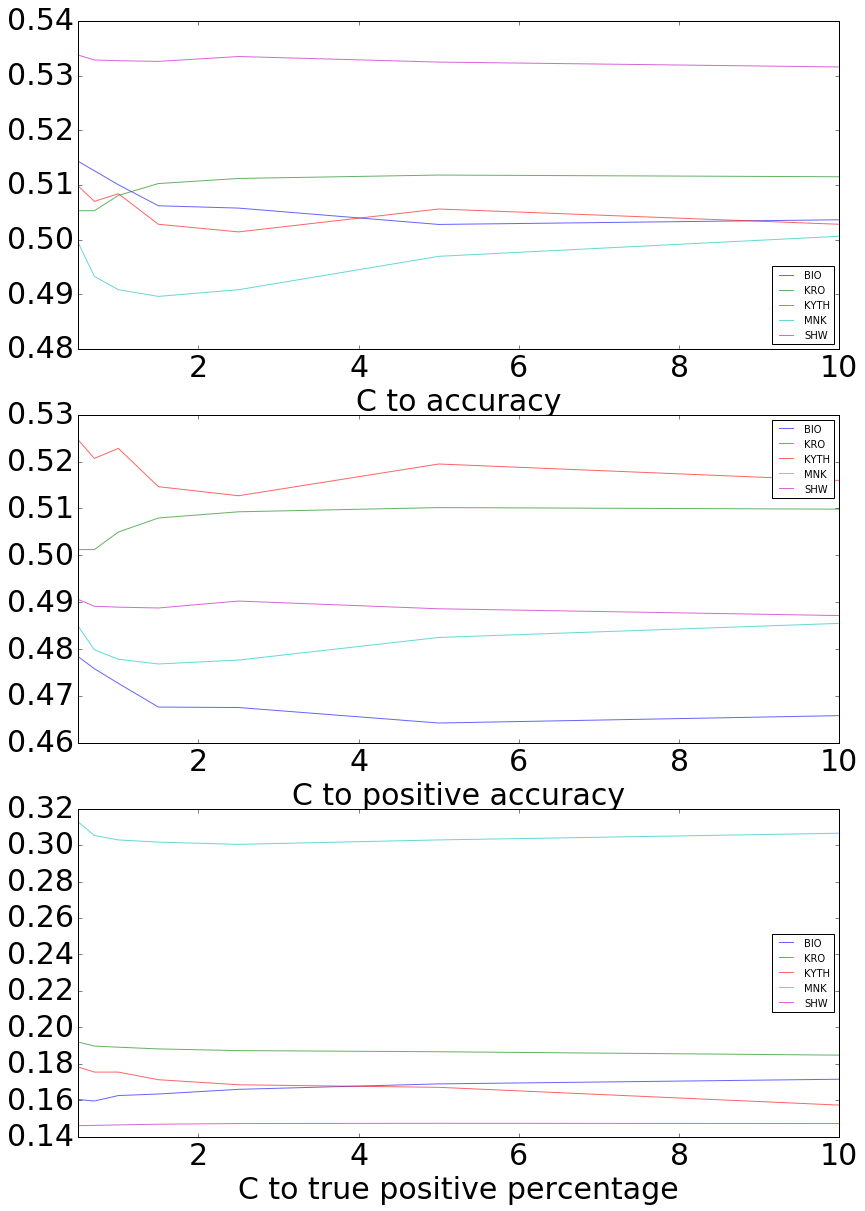

In [60]:
results = cresults

plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

ax1 = plt.subplot2grid((3,2), (0,0))
for name, group in results.groupby('stock'):
    # since we are counting values it makes sense to regularize the counts
    group.groupby('C').agg('mean')['accuracy'].plot(kind='line', label=name, alpha=alpha)
ax1.set_xlabel('C to accuracy')
plt.legend(loc='best', prop={'size':10})

ax2 = plt.subplot2grid((3,2), (1, 0))
for name, group in results.groupby('stock'):
    # since we are counting values it makes sense to regularize the counts
    group.groupby('C').agg('mean')['positive acc'].plot(kind='line', label=name, alpha=alpha)
ax2.set_xlabel('C to positive accuracy')
plt.legend(loc='best', prop={'size':10})

ax3 = plt.subplot2grid((3,2), (2,0))
for name, group in results.groupby('stock'):
    group.replace(np.nan, 0).groupby('C').agg('mean')['true positive'].plot(kind='line', label=name, alpha=alpha)
ax3.set_xlabel('C to true positive percentage')
plt.legend(loc='best', prop={'size':10})

In [61]:
iresults = get_results([LogisticRegression(intercept_scaling=i) for i in intercept_scalings])

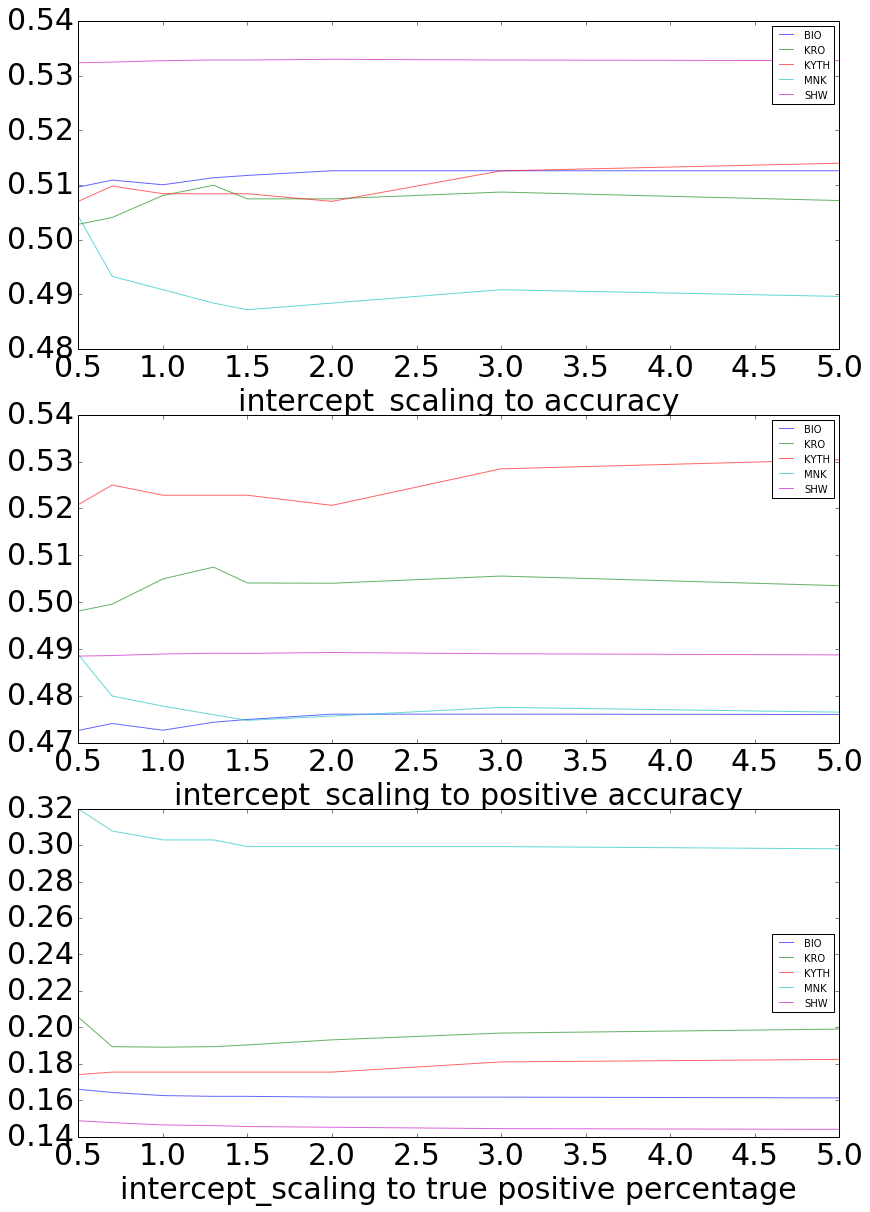

In [62]:
results = iresults

plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

ax1 = plt.subplot2grid((3,2), (0,0))
for name, group in results.groupby('stock'):
    # since we are counting values it makes sense to regularize the counts
    group.groupby('intercept_scaling').agg('mean')['accuracy'].plot(kind='line', label=name, alpha=alpha)
ax1.set_xlabel('intercept_scaling to accuracy')
plt.legend(loc='best', prop={'size':10})

ax2 = plt.subplot2grid((3,2), (1, 0))
for name, group in results.groupby('stock'):
    # since we are counting values it makes sense to regularize the counts
    group.groupby('intercept_scaling').agg('mean')['positive acc'].plot(kind='line', label=name, alpha=alpha)
ax2.set_xlabel('intercept_scaling to positive accuracy')
plt.legend(loc='best', prop={'size':10})

ax3 = plt.subplot2grid((3,2), (2,0))
for name, group in results.groupby('stock'):
    group.replace(np.nan, 0).groupby('intercept_scaling').agg('mean')['true positive'].plot(kind='line', label=name, alpha=alpha)
ax3.set_xlabel('intercept_scaling to true positive percentage')
plt.legend(loc='best', prop={'size':10})

In [63]:
presults = get_results([LogisticRegression(penalty=p) for p in penaltys])

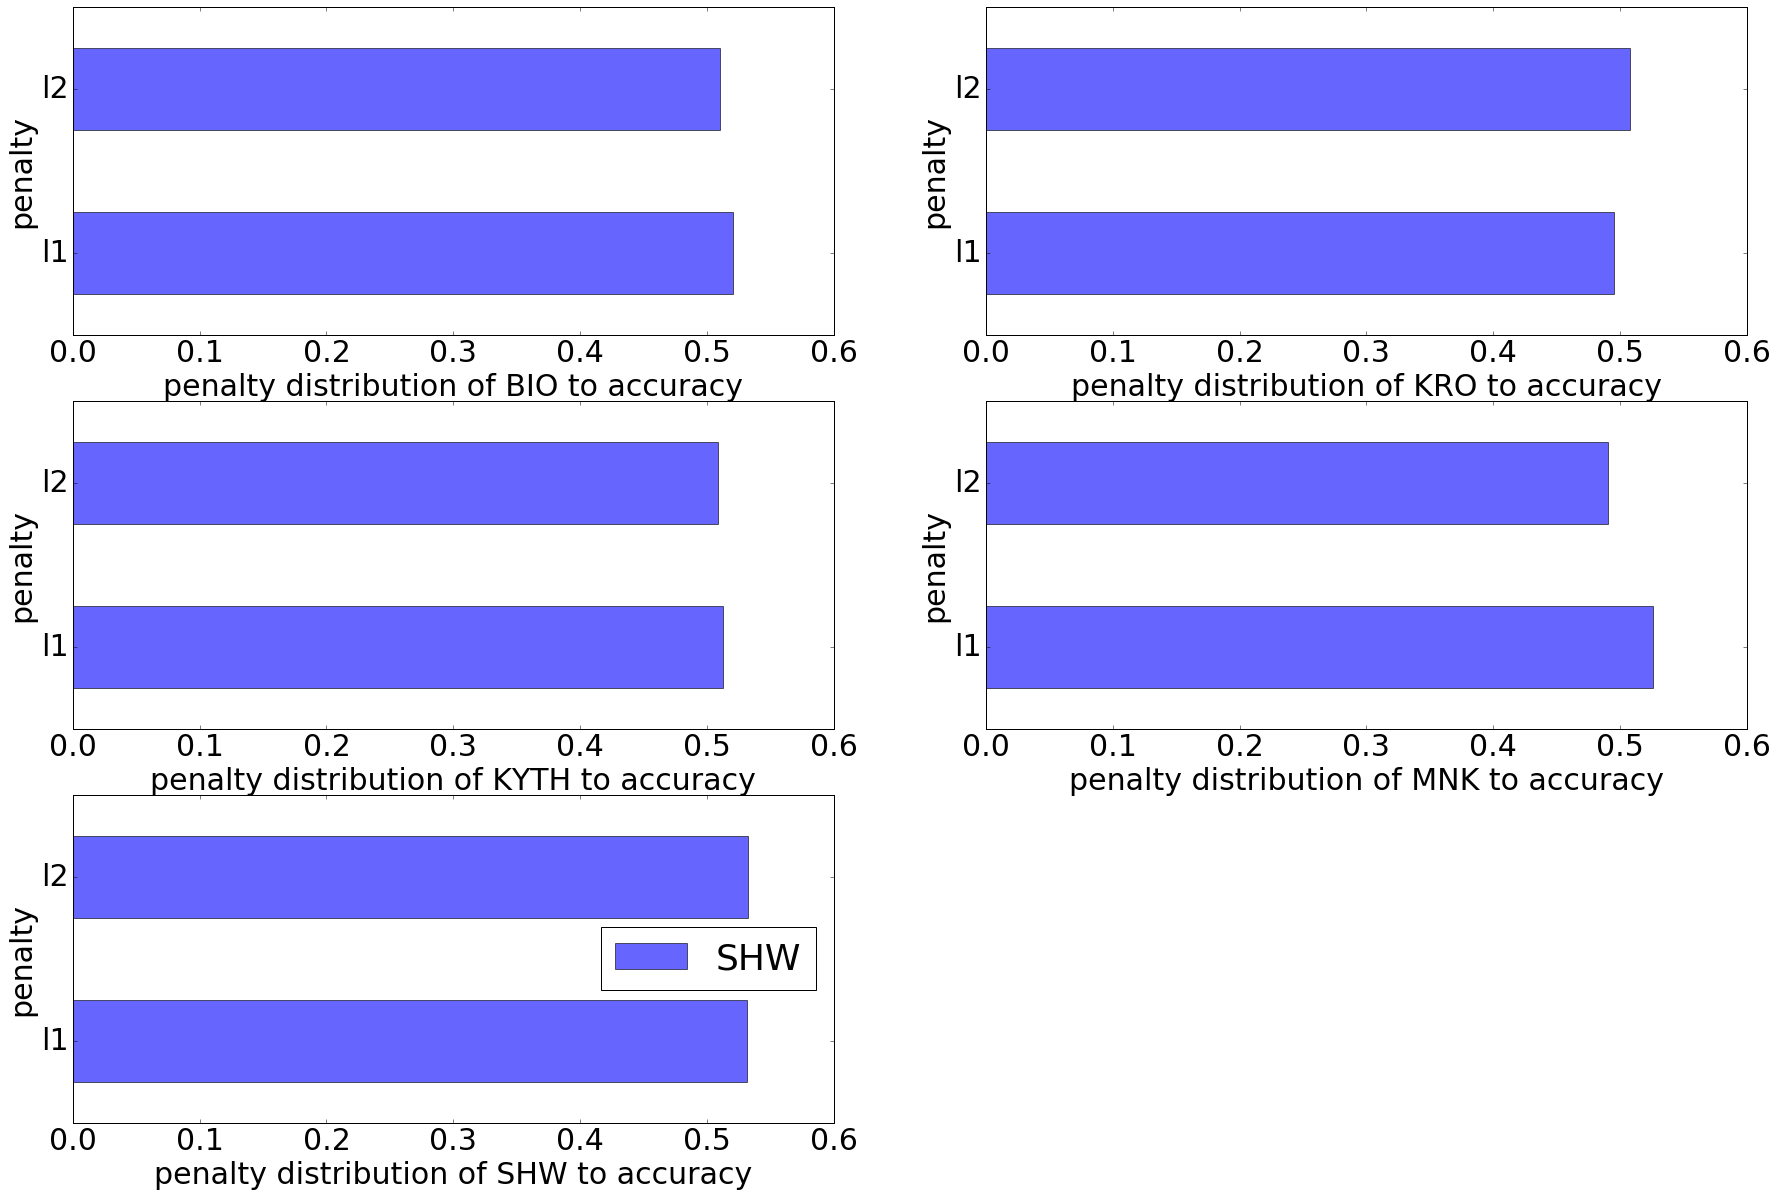

In [64]:
results = presults

plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

locations = [(0,0), (0,1), (1,0), (1,1), (2,0), (2,1)]

for i, (name, group) in enumerate(results.groupby('stock')):
    ax1 = plt.subplot2grid((3,2), locations[i])
    # since we are counting values it makes sense to regularize the counts
    group.replace(np.nan, 1).groupby('penalty').agg('mean')['accuracy'].plot(kind='barh', label=name, alpha=alpha)
    ax1.set_xlabel('penalty distribution of ' + name + ' to accuracy')
plt.legend(loc='best')

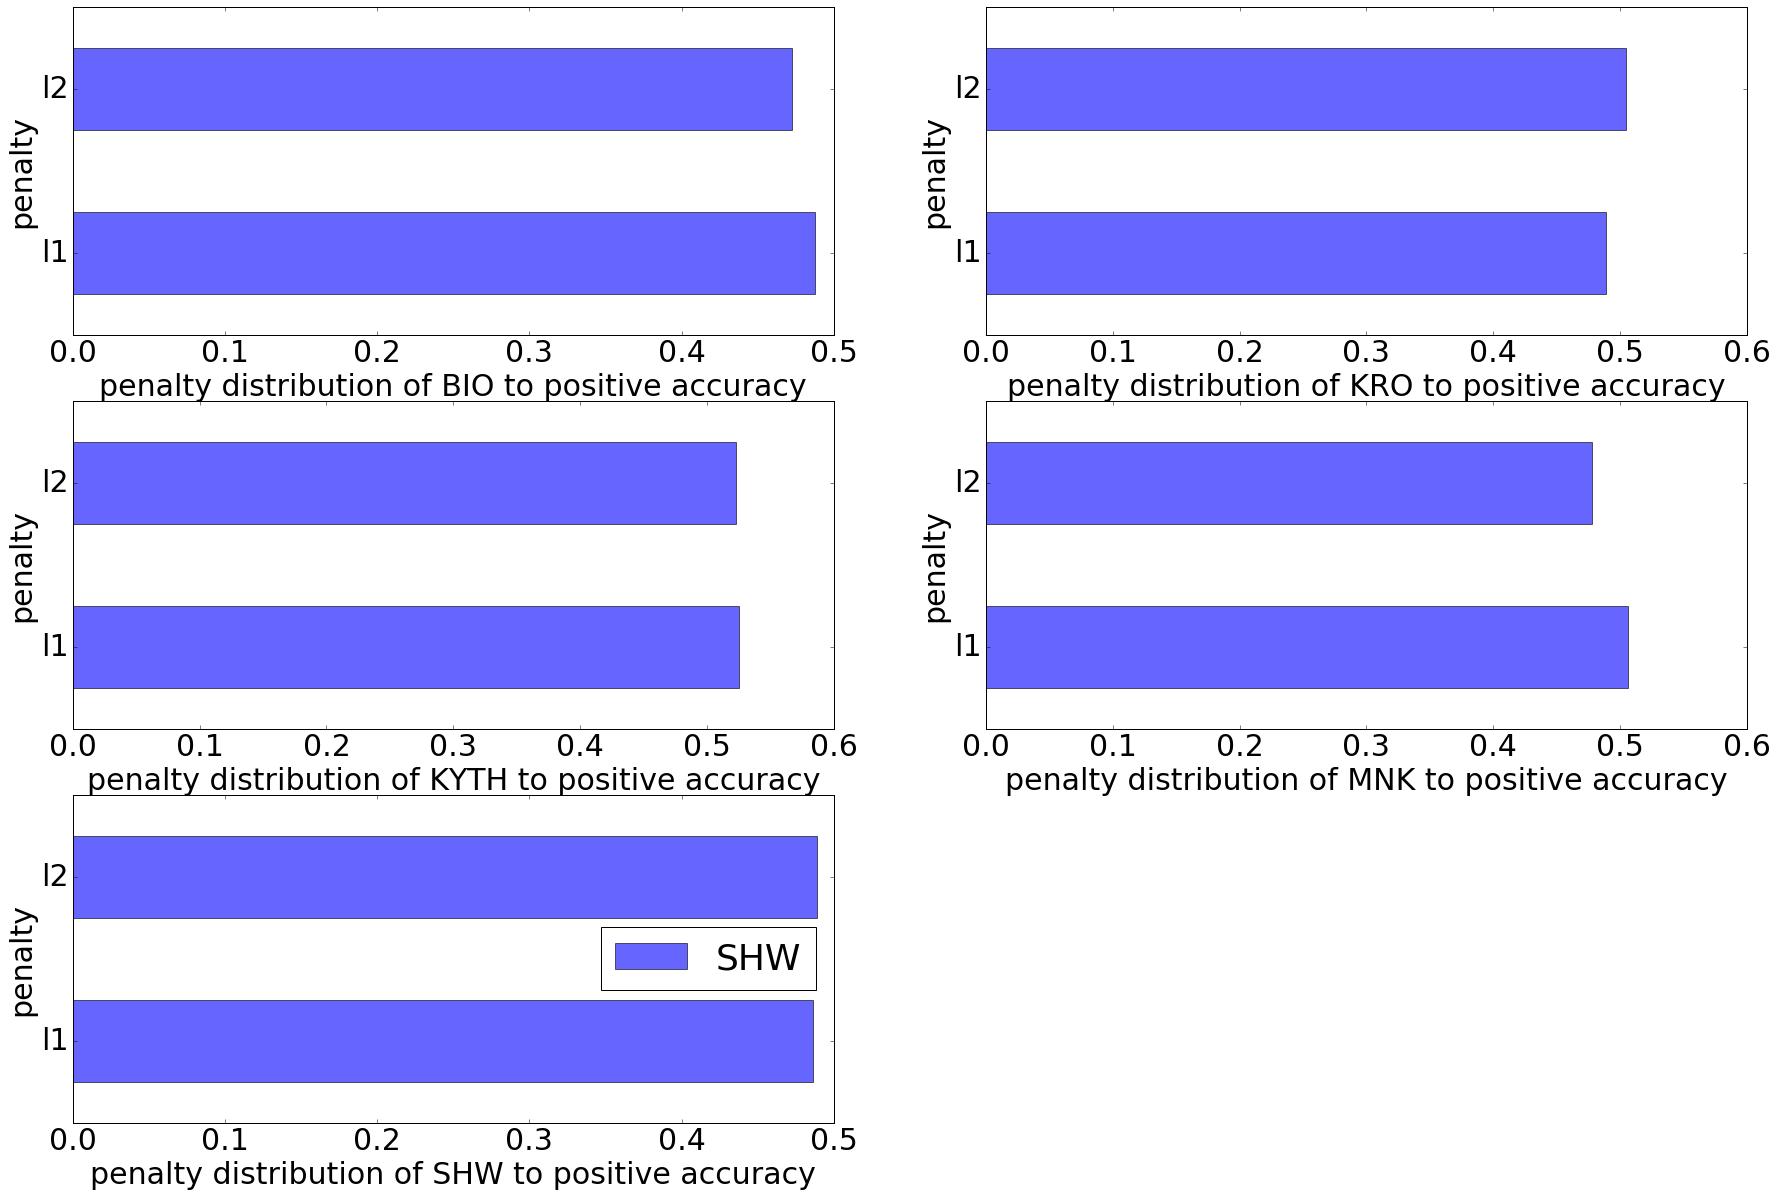

In [65]:
plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

locations = [(0,0), (0,1), (1,0), (1,1), (2,0), (2,1)]

for i, (name, group) in enumerate(results.groupby('stock')):
    ax1 = plt.subplot2grid((3,2), locations[i])
    # since we are counting values it makes sense to regularize the counts
    group.replace(np.nan, 1).groupby('penalty').agg('mean')['positive acc'].plot(kind='barh', label=name, alpha=alpha)
    ax1.set_xlabel('penalty distribution of ' + name + ' to positive accuracy')
plt.legend(loc='best')

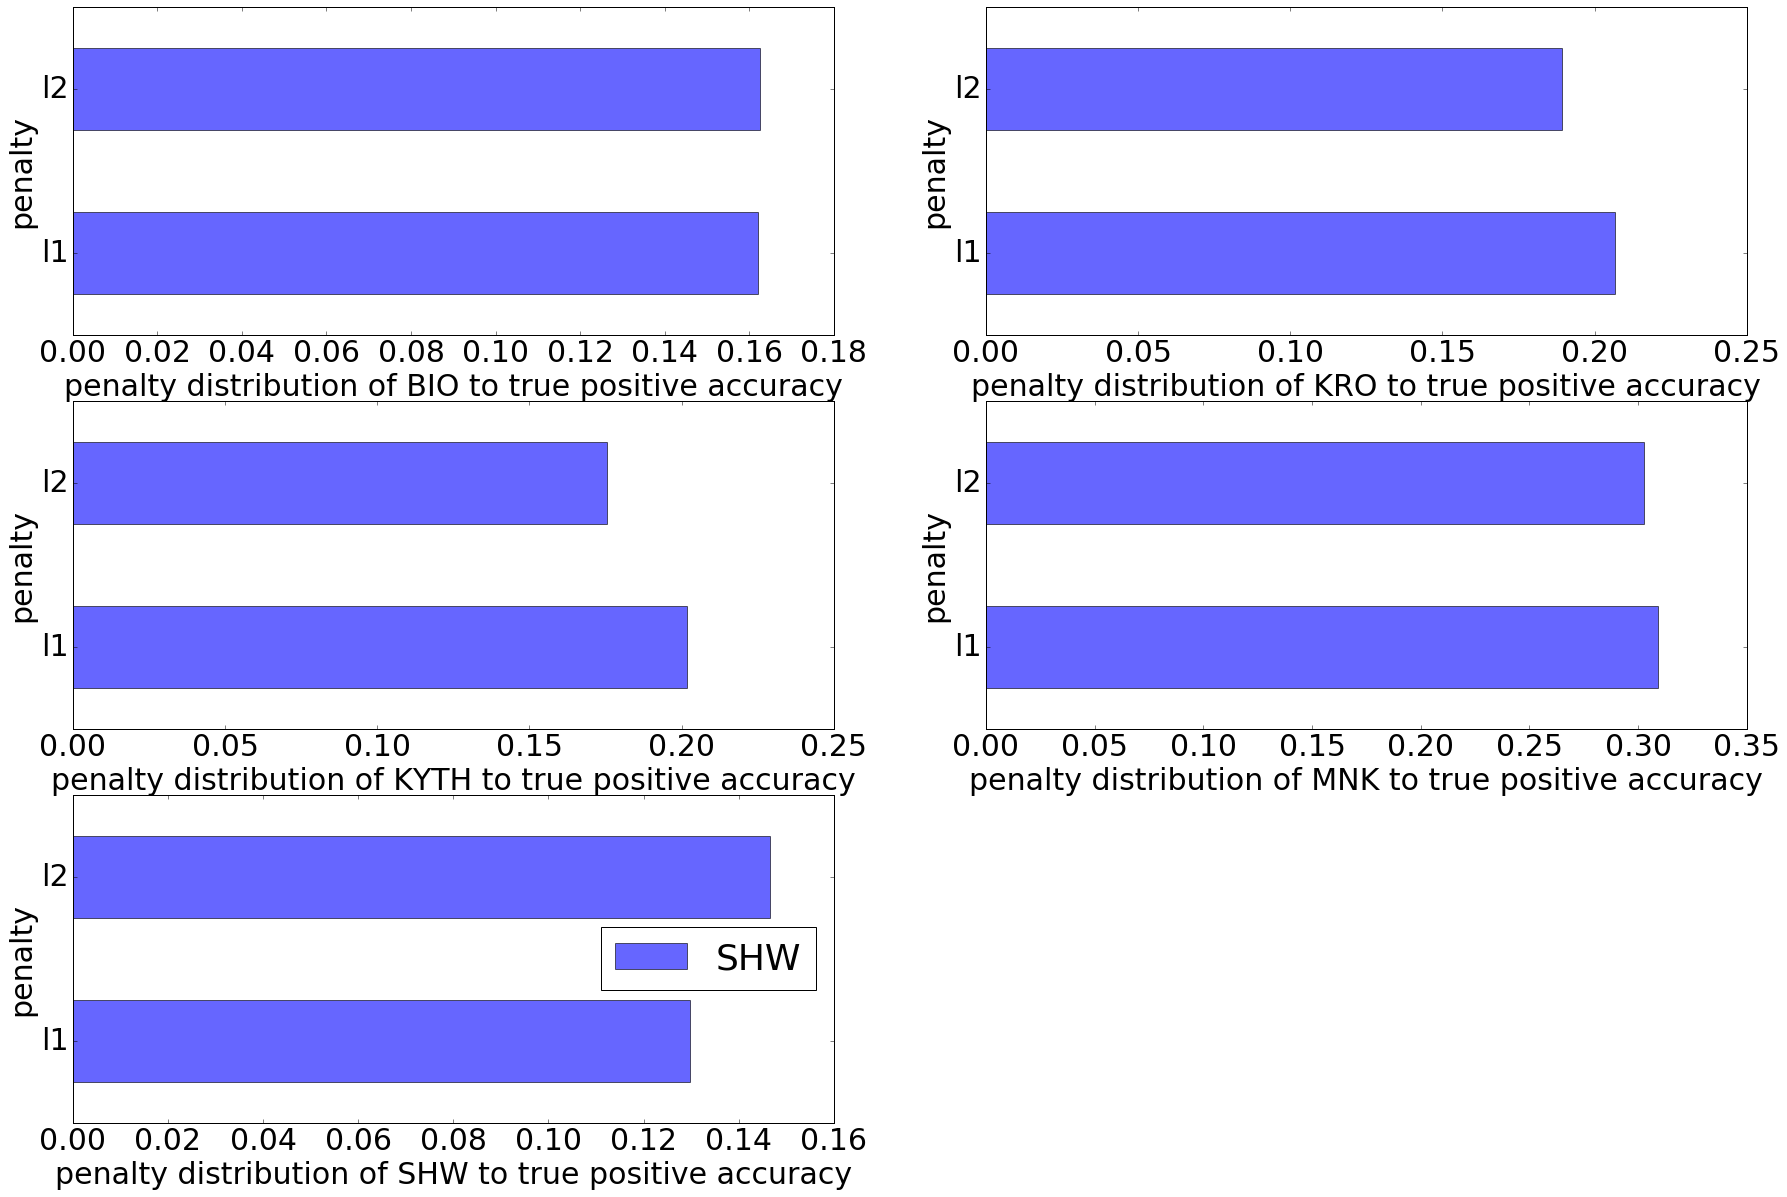

In [66]:
plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

locations = [(0,0), (0,1), (1,0), (1,1), (2,0), (2,1)]

for i, (name, group) in enumerate(results.groupby('stock')):
    ax1 = plt.subplot2grid((3,2), locations[i])
    # since we are counting values it makes sense to regularize the counts
    group.replace(np.nan, 1).groupby('penalty').agg('mean')['true positive'].plot(kind='barh', label=name, alpha=alpha)
    ax1.set_xlabel('penalty distribution of ' + name + ' to true positive accuracy')
plt.legend(loc='best')

# Variance Reduction
We will try 3 approches. 

    1. using standard sklearn feature selection. 
    2. using QuarterClusterer try using data with less variance.
    3. using relation strength classifier.

In [67]:
from sklearn.linear_model import LogisticRegression

penalty = 'l2'
intercept_scaling = 5
C = 5
model = LogisticRegression(C=C, penalty=penalty, intercept_scaling=intercept_scaling, n_jobs=-1)
accs = run_model(model)

LogisticRegression(C=5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=5, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Accuracy: 0.5097338238081326


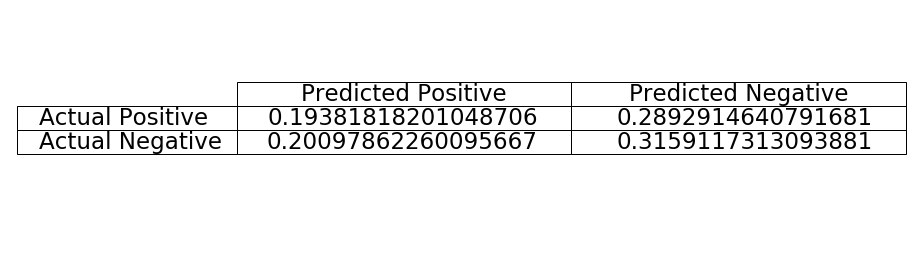

0.49093148613814536


In [68]:
concated_accs = ConfusionMatrix.concat(*list(accs.values()))
concated_accs.plot()
print(concated_accs.true_acc())

## Standard feature selection

We have plenty of samples so it seems wiser to use mutual_info score func, and trying to remove features by those who have small variance.

In [69]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

results = []
for i in range(1, 251, 10):
    filtered_stocks = [(pandas.DataFrame(SelectKBest(score_func=mutual_info_classif, k=i).fit_transform(data, classes)), pandas.Series(classes)) for data, classes in stocks]
    results.append((i, run_model(model, filtered_stocks)))
    
kbest_results = results

In [70]:
kbest_temp = kbest_results

In [71]:
kbest_results = []
for k, acc in kbest_temp:
    for tsn, cm in acc.items():
        kbest_results.append((k, tsn, cm.accuracy, cm.true_acc(), cm.false_acc(), cm.TruePos))

results = pandas.DataFrame(kbest_results, columns=('Kfeatures', 'stock', 'accuracy', 'positive acc', 'negative acc', 'true positive'))

/home/eytan/work/Stockifier/Utilities/confusion_matrix.py:63: RuntimeWarning: invalid value encountered in double_scalars
  return self.TruePos / (self.TruePos + self.FalsePos)


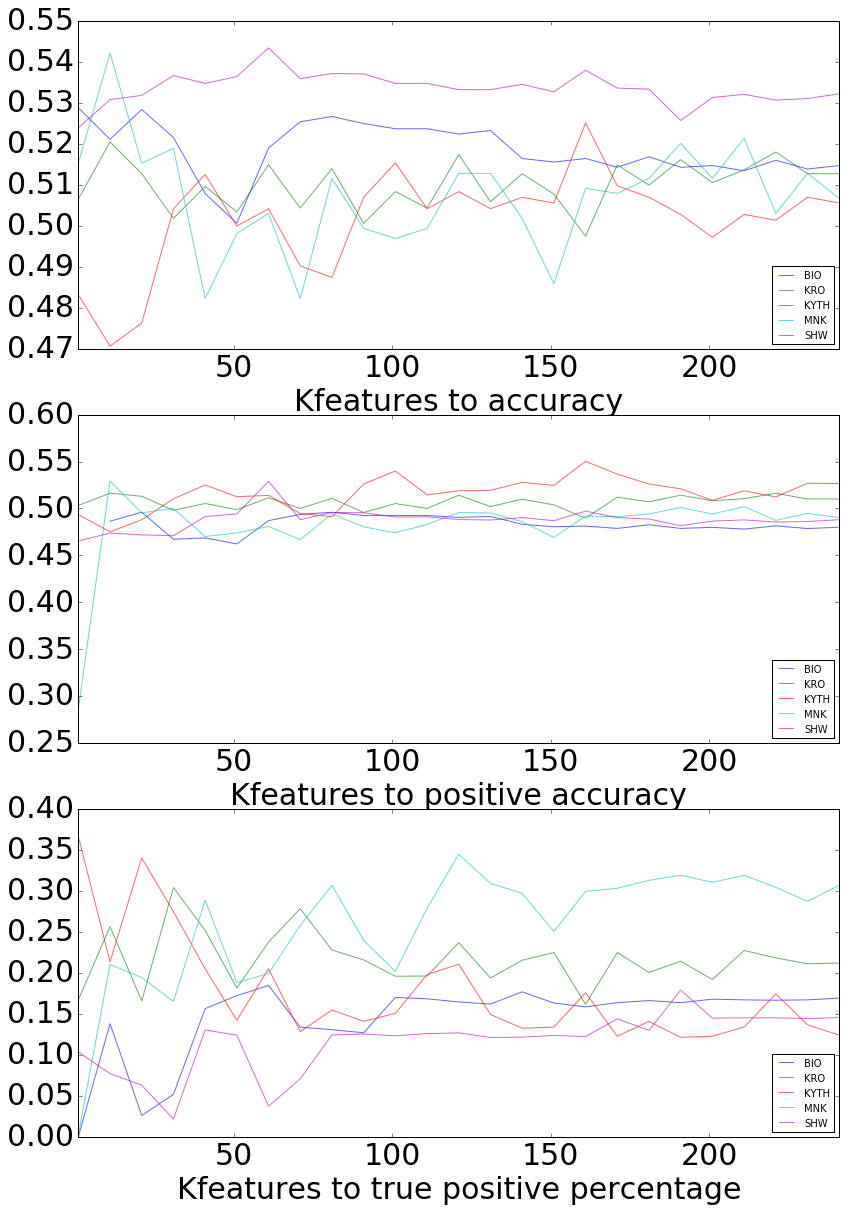

In [72]:
plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

ax1 = plt.subplot2grid((3,2), (0,0))
for name, group in results.groupby('stock'):
    # since we are counting values it makes sense to regularize the counts
    group.groupby('Kfeatures').agg('mean')['accuracy'].plot(kind='line', label=name, alpha=alpha)
ax1.set_xlabel('Kfeatures to accuracy')
plt.legend(loc='best', prop={'size':10})

ax2 = plt.subplot2grid((3,2), (1, 0))
for name, group in results.groupby('stock'):
    # since we are counting values it makes sense to regularize the counts
    group.groupby('Kfeatures').agg('mean')['positive acc'].plot(kind='line', label=name, alpha=alpha)
ax2.set_xlabel('Kfeatures to positive accuracy')
plt.legend(loc='best', prop={'size':10})

ax3 = plt.subplot2grid((3,2), (2,0))
for name, group in results.groupby('stock'):
    group.replace(np.nan, 0).groupby('Kfeatures').agg('mean')['true positive'].plot(kind='line', label=name, alpha=alpha)
ax3.set_xlabel('Kfeatures to true positive percentage')
plt.legend(loc='best', prop={'size':10})

In [73]:
aggr = results.groupby('Kfeatures').agg('mean')
aggr.loc[aggr['accuracy'] == aggr['accuracy'].max()]

,accuracy,positive acc,negative acc,true positive
Kfeatures,,,,
121,0.518843,0.501469,0.532161,0.21645


In [74]:
aggr.loc[aggr['positive acc'] == aggr['positive acc'].max()]

,accuracy,positive acc,negative acc,true positive
Kfeatures,,,,
61,0.516909,0.504421,0.523473,0.17254


In [75]:
aggr.loc[aggr['true positive'] == aggr['true positive'].max()]

,accuracy,positive acc,negative acc,true positive
Kfeatures,,,,
121,0.518843,0.501469,0.532161,0.21645


In [76]:
from sklearn.feature_selection import VarianceThreshold

variance_threshold_results = []
for i in range(60, 101):
    try:
        thresh = float(i)/100
        filtered_stocks = [(pandas.DataFrame(VarianceThreshold(threshold=thresh).fit_transform(data, classes)), 
                                 pandas.Series(classes)) for data, classes in stocks]
        variance_threshold_results.append((thresh, run_model(model, filtered_stocks)))
    except Exception as e:
        print('Skipping threshold {} as it doesnt have enough variance: {}'.format(float(i)/100, str(e)))

In [77]:
variance_threshold_temp = variance_threshold_results

In [78]:
variance_threshold_results = []
for t, acc in variance_threshold_temp:
    for tsn, cm in acc.items():
        variance_threshold_results.append((t, tsn, cm.accuracy, cm.true_acc(), cm.false_acc(), cm.TruePos))

results = pandas.DataFrame(variance_threshold_results, columns=('VThreshold', 'stock', 'accuracy', 'positive acc', 'negative acc', 'true positive'))

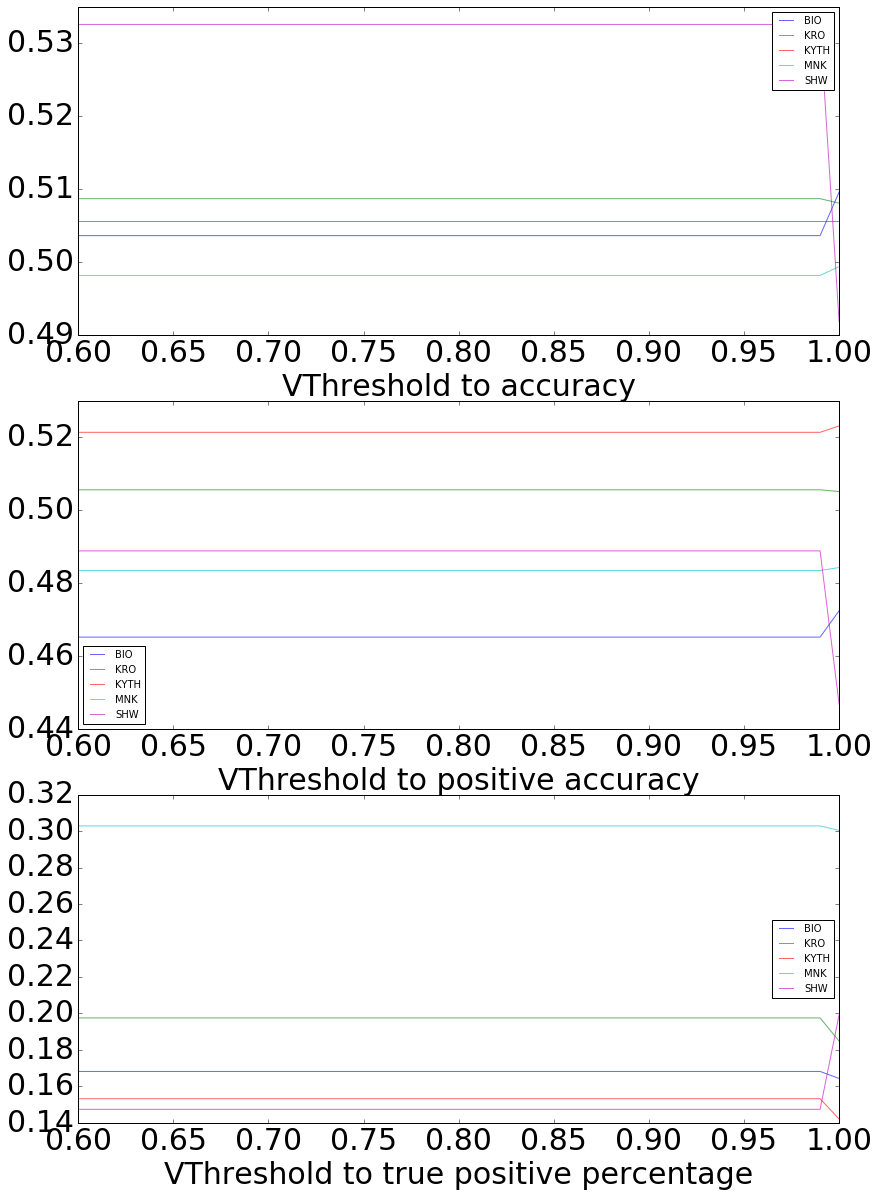

In [79]:
plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

ax1 = plt.subplot2grid((3,2), (0,0))
for name, group in results.groupby('stock'):
    # since we are counting values it makes sense to regularize the counts
    group.groupby('VThreshold').agg('mean')['accuracy'].plot(kind='line', label=name, alpha=alpha)
ax1.set_xlabel('VThreshold to accuracy')
plt.legend(loc='best', prop={'size':10})

ax2 = plt.subplot2grid((3,2), (1, 0))
for name, group in results.groupby('stock'):
    # since we are counting values it makes sense to regularize the counts
    group.groupby('VThreshold').agg('mean')['positive acc'].plot(kind='line', label=name, alpha=alpha)
ax2.set_xlabel('VThreshold to positive accuracy')
plt.legend(loc='best', prop={'size':10})

ax3 = plt.subplot2grid((3,2), (2,0))
for name, group in results.groupby('stock'):
    group.replace(np.nan, 0).groupby('VThreshold').agg('mean')['true positive'].plot(kind='line', label=name, alpha=alpha)
ax3.set_xlabel('VThreshold to true positive percentage')
plt.legend(loc='best', prop={'size':10})

## Connection Strength Classifier

In [87]:
from Utilities.clustering import StrengthCalc

sc = StrengthCalc()

In [81]:
from Classifiers.classifiers import ConnectionStrengthClassifier

# dictionary of market name to strength
stock_strengths = [sc.get_strength_stock(sn, 5, 325, 2, 0.1) for sn in stock_names]

clf = ConnectionStrengthClassifier()

In [82]:
from Utilities import clean_market_name

cols = []
for d, c in stocks:
    cols.extend(d.columns)
all_cols = set(cols)

strengths = []
connections_cols = []
for i, sn in enumerate(stock_names):
    cur_cols = []
    cur_strengths = []
    for m in ld.get_market_names():
        cur_cols.append(list(filter(lambda c: clean_market_name(m) in c, all_cols)))
        cur_strengths.append(stock_strengths[i][m])
    connections_cols.append(cur_cols)
    strengths.append(cur_strengths)

In [83]:
def run_strength_model(model, stocks=stocks, strength=strengths, cols=connections_cols):
    scores = {sn: [] for sn in stock_names}
    for sn, (data, classes), st, cs in zip(stock_names, stocks, strength, cols):
        scores[sn] = ConfusionMatrix((data, classes), model, st, cs) 
    return scores

best connection strength with deafult logistic regression 

In [84]:
import Classifiers.classifiers
import sklearn.tree

con_model = Classifiers.classifiers.ConnectionStrengthClassifier(base_estimator=model)
st_accuracies = run_strength_model(con_model, stocks)

In [85]:
import Classifiers
import sklearn
from itertools import product

thresholds = [0.001, 0.08, 0.15]
combined_weights = [0.1, 0.5, 0.9]
base_strength = [0.1, 0.5, 0.9]

# t_models = [Classifiers.classifiers.ConnectionStrengthClassifier(threshold=t, base_estimator=model) for t in thresholds]
# c_models = [Classifiers.classifiers.ConnectionStrengthClassifier(combined_weight=c, base_estimator=model) for c in combined_weights]
# b_models = [Classifiers.classifiers.ConnectionStrengthClassifier(base_strength=b, base_estimator=model) for b in base_strength]
sct_models = [Classifiers.classifiers.ConnectionStrengthClassifier(threshold=t, base_strength=bs, combined_weight=w, 
                                                                   base_estimator=model) 
          for t, w, bs in product(thresholds, combined_weights, base_strength)]

In [86]:
# t_accuracies = list(map(run_strength_model, t_models))
# c_accuracies = list(map(run_strength_model, c_models))
# b_accuracies = list(map(run_strength_model, b_models))
sct_accuracies = list(map(run_strength_model, sct_models))

Here we gonna check how combined weight and base strength effects in order to find the best connection strength for logistic regression 

In [88]:
def get_connection_results(models=sct_models, accuracies=sct_accuracies):
    if accuracies is None:
        accuracies = list(map(run_strength_model, models))
    # data should be list of lists and each row should be:
    # criterion, max_depth, min_samples, stock, accuracy
    data = []
    for tmodel, taccs in zip(models, accuracies):
        for tsn, cm in taccs.items():
            data.append((tmodel.threshold, tmodel.combined_weight, tmodel.base_strength, tsn, cm.accuracy, cm.true_acc(), cm.false_acc(), cm.TruePos))
    results = DataFrame(data, columns=('threshold', 'combined_weight', 'base_strength', 'stock', 'accuracy', 'positive acc', 'negative acc', 'true positive'))
    return results

In [89]:
results = get_connection_results()

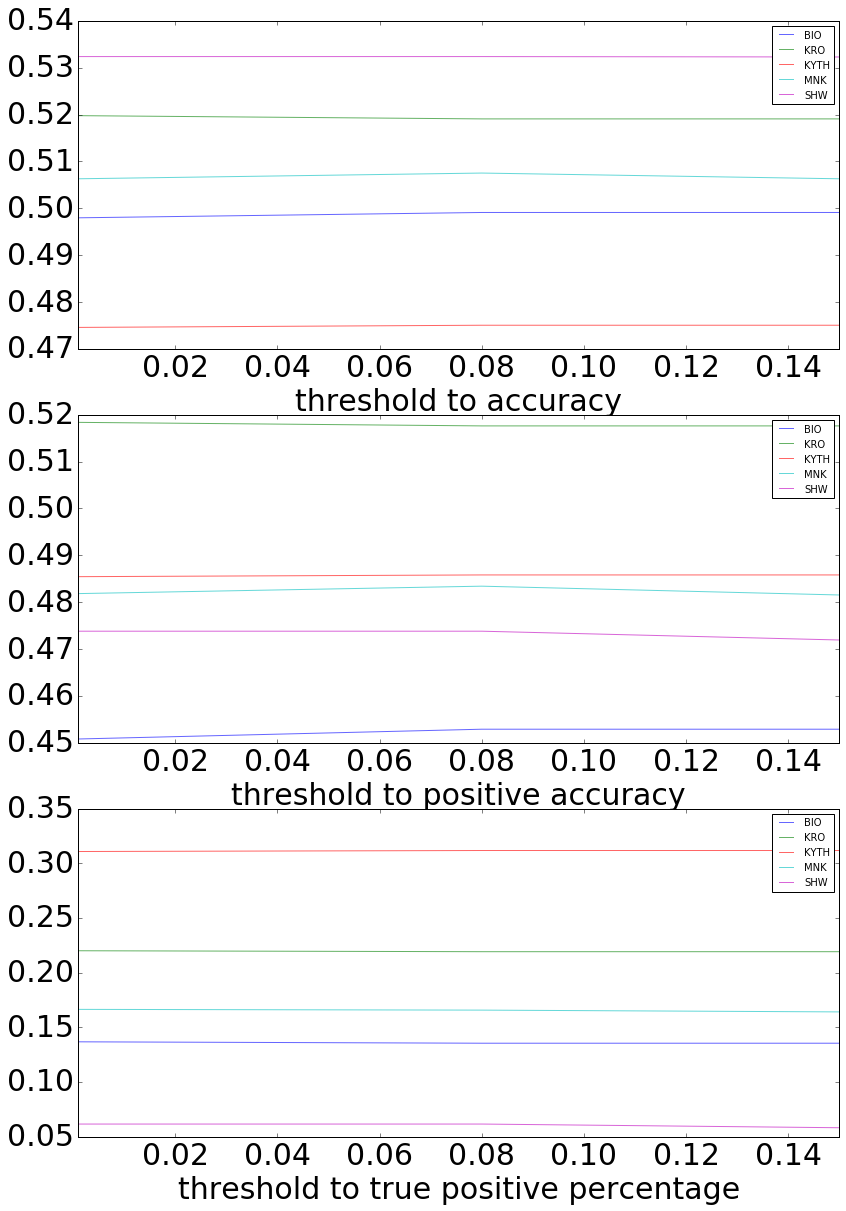

In [90]:
plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

ax1 = plt.subplot2grid((3,2), (0,0))
for name, group in results.groupby('stock'):
    # since we are counting values it makes sense to regularize the counts
    group.groupby('threshold').agg('mean')['accuracy'].plot(kind='line', label=name, alpha=alpha)
ax1.set_xlabel('threshold to accuracy')
plt.legend(loc='best', prop={'size':10})

ax2 = plt.subplot2grid((3,2), (1, 0))
for name, group in results.groupby('stock'):
    # since we are counting values it makes sense to regularize the counts
    group.groupby('threshold').agg('mean')['positive acc'].plot(kind='line', label=name, alpha=alpha)
ax2.set_xlabel('threshold to positive accuracy')
plt.legend(loc='best', prop={'size':10})

ax3 = plt.subplot2grid((3,2), (2,0))
for name, group in results.groupby('stock'):
    group.replace(np.nan, 0).groupby('threshold').agg('mean')['true positive'].plot(kind='line', label=name, alpha=alpha)
ax3.set_xlabel('threshold to true positive percentage')
plt.legend(loc='best', prop={'size':10})

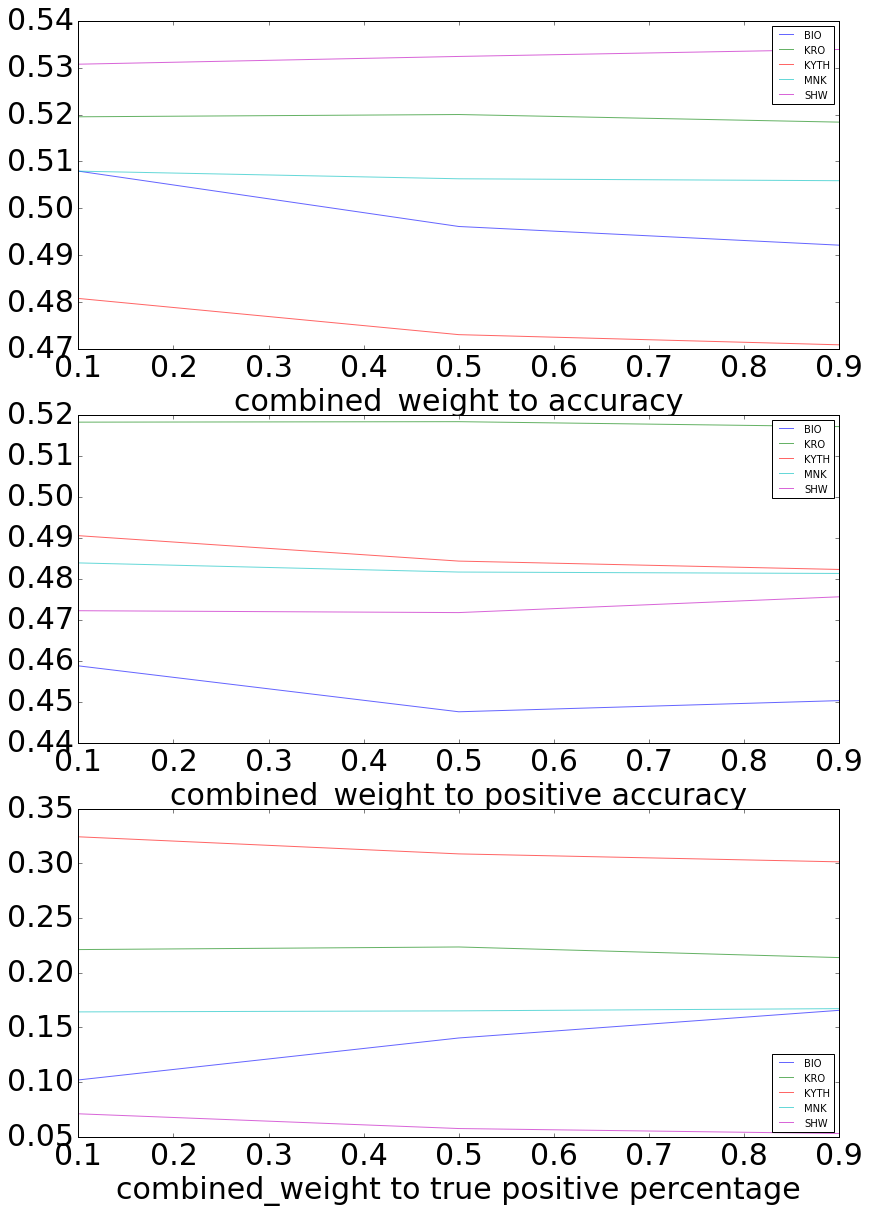

In [91]:
plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

ax1 = plt.subplot2grid((3,2), (0,0))
for name, group in results.groupby('stock'):
    # since we are counting values it makes sense to regularize the counts
    group.groupby('combined_weight').agg('mean')['accuracy'].plot(kind='line', label=name, alpha=alpha)
ax1.set_xlabel('combined_weight to accuracy')
plt.legend(loc='best', prop={'size':10})

ax2 = plt.subplot2grid((3,2), (1, 0))
for name, group in results.groupby('stock'):
    # since we are counting values it makes sense to regularize the counts
    group.groupby('combined_weight').agg('mean')['positive acc'].plot(kind='line', label=name, alpha=alpha)
ax2.set_xlabel('combined_weight to positive accuracy')
plt.legend(loc='best', prop={'size':10})

ax3 = plt.subplot2grid((3,2), (2,0))
for name, group in results.groupby('stock'):
    group.replace(np.nan, 0).groupby('combined_weight').agg('mean')['true positive'].plot(kind='line', label=name, alpha=alpha)
ax3.set_xlabel('combined_weight to true positive percentage')
plt.legend(loc='best', prop={'size':10})

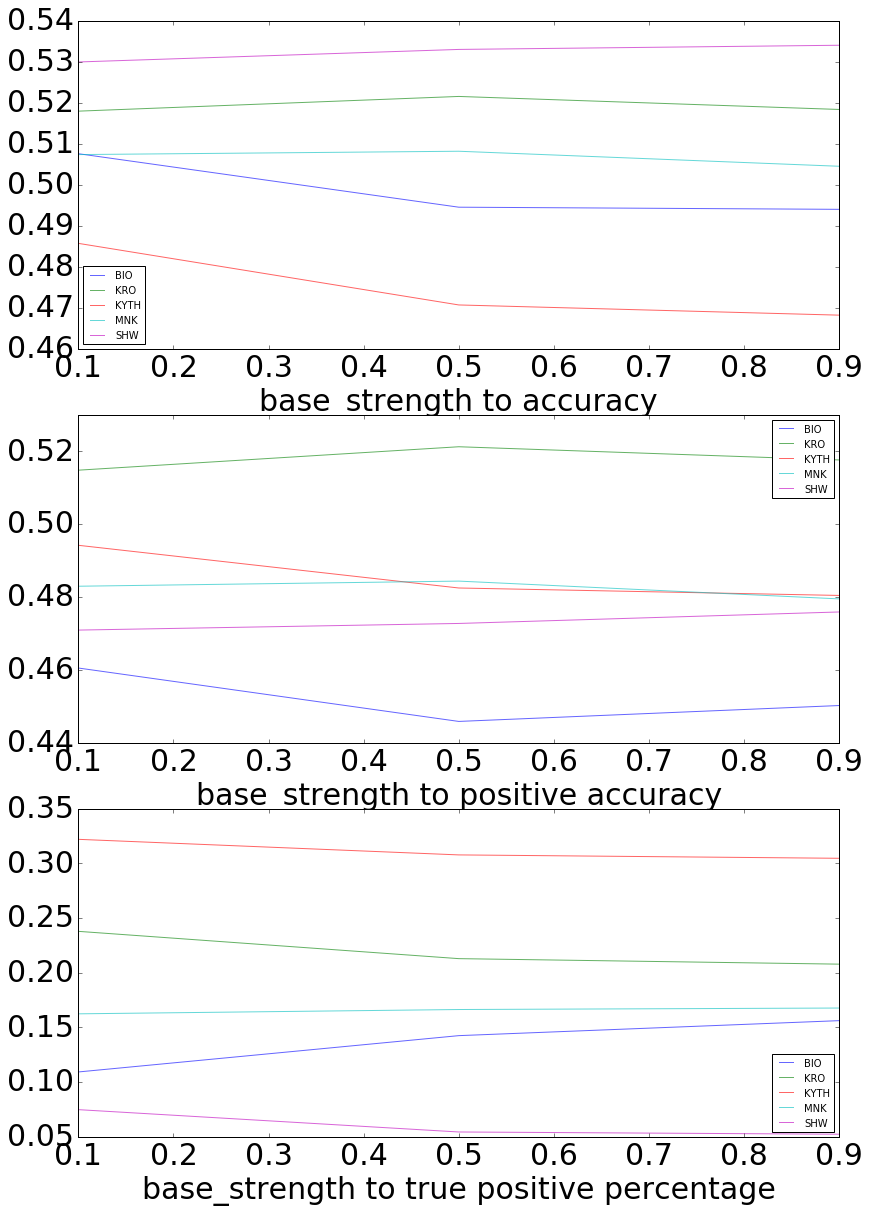

In [92]:
plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

ax1 = plt.subplot2grid((3,2), (0,0))
for name, group in results.groupby('stock'):
    # since we are counting values it makes sense to regularize the counts
    group.groupby('base_strength').agg('mean')['accuracy'].plot(kind='line', label=name, alpha=alpha)
ax1.set_xlabel('base_strength to accuracy')
plt.legend(loc='best', prop={'size':10})

ax2 = plt.subplot2grid((3,2), (1, 0))
for name, group in results.groupby('stock'):
    # since we are counting values it makes sense to regularize the counts
    group.groupby('base_strength').agg('mean')['positive acc'].plot(kind='line', label=name, alpha=alpha)
ax2.set_xlabel('base_strength to positive accuracy')
plt.legend(loc='best', prop={'size':10})

ax3 = plt.subplot2grid((3,2), (2,0))
for name, group in results.groupby('stock'):
    group.replace(np.nan, 0).groupby('base_strength').agg('mean')['true positive'].plot(kind='line', label=name, alpha=alpha)
ax3.set_xlabel('base_strength to true positive percentage')
plt.legend(loc='best', prop={'size':10})

In [94]:
aggr = results.groupby(['threshold', 'base_strength', 'combined_weight']).agg('mean')
print(aggr.accuracy.max())
print(aggr['positive acc'].max())
print(aggr['true positive'].max())

0.514891928998
0.490739453194
0.184327430774


In [95]:
aggr = results.groupby(['threshold', 'base_strength', 'combined_weight']).agg('mean')
aggr.loc[aggr['accuracy'] == aggr['accuracy'].max()]

,,,accuracy,positive acc,negative acc,true positive
threshold,base_strength,combined_weight,,,,
0.15,0.1,0.1,0.514892,0.490739,0.519225,0.178359


In [96]:
aggr.loc[aggr['positive acc'] == aggr['positive acc'].max()]

,,,accuracy,positive acc,negative acc,true positive
threshold,base_strength,combined_weight,,,,
0.15,0.1,0.1,0.514892,0.490739,0.519225,0.178359


In [97]:
aggr.loc[aggr['true positive'] == aggr['true positive'].max()]

,,,accuracy,positive acc,negative acc,true positive
threshold,base_strength,combined_weight,,,,
0.15,0.1,0.9,0.506202,0.482228,0.512291,0.184327


ConnectionStrengthClassifier(base_estimator=LogisticRegression(C=5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=5, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
               base_strength=0.063, combined_weight=0.1, threshold=0.15)
Accuracy: 0.5172773626949724


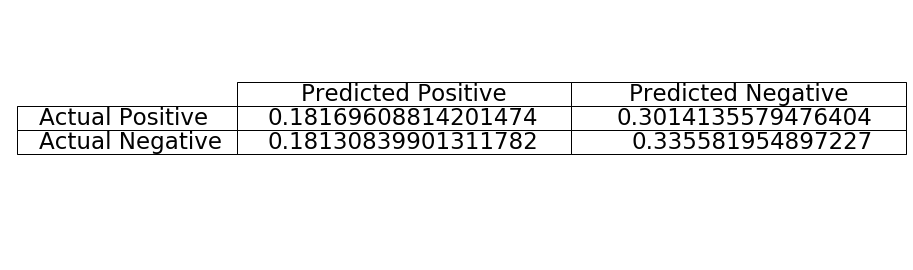

In [113]:
sct_model = Classifiers.classifiers.ConnectionStrengthClassifier(threshold=0.15, base_strength=0.063, combined_weight=0.1, 
                                                                   base_estimator=model)
sct_cm = run_strength_model(sct_model)
ConfusionMatrix.concat(iterator=sct_cm.values()).plot()

### Bagging

In [114]:
from sklearn.ensemble import BaggingClassifier
base_estimator = model
n_estimators = [10, 20, 30]
max_samples = [0.5, 0.7, 0.9, 1]
max_features = [0.5, 0.7, 0.9, 1]
n_jobs = 4

bagging_models = [BaggingClassifier(max_samples=s, max_features=f, n_estimators=n, base_estimator=model, n_jobs=n_jobs) 
          for n, s, f in product(n_estimators, max_samples, max_features)]

In [115]:
bagging_accs = list(map(run_model, bagging_models))

In [116]:
def get_bagging_results(models=bagging_models, accuracies=bagging_accs):
    if accuracies is None:
        accuracies = list(map(run_model_t, models))
    # data should be list of lists and each row should be:
    # criterion, max_depth, min_samples, stock, accuracy
    data = []
    for tmodel, taccs in zip(models, accuracies):
        for tsn, cm in taccs.items():
            data.append((tmodel.max_samples, tmodel.max_features, tmodel.n_estimators, tsn, cm.accuracy, cm.true_acc(), cm.false_acc(), cm.TruePos))
    results = DataFrame(data, columns=('max_samples', 'max_features', 'n_estimators', 'stock', 'accuracy', 'positive acc', 'negative acc', 'true positive'))
    return results

In [117]:
results = get_bagging_results()

/home/eytan/work/Stockifier/Utilities/confusion_matrix.py:63: RuntimeWarning: invalid value encountered in double_scalars
  return self.TruePos / (self.TruePos + self.FalsePos)
/home/eytan/work/Stockifier/Utilities/confusion_matrix.py:66: RuntimeWarning: invalid value encountered in double_scalars
  return self.TrueNeg / (self.TrueNeg + self.FalseNeg)


In [118]:
aggr = results.groupby(['max_samples', 'max_features', 'n_estimators']).agg('mean')
aggr.loc[aggr['accuracy'] == aggr['accuracy'].max()]

,,,accuracy,positive acc,negative acc,true positive
max_samples,max_features,n_estimators,,,,
0.9,1.0,30,0.522765,0.537331,0.530701,0.19534


In [119]:
aggr.loc[aggr['positive acc'] == aggr['positive acc'].max()]

,,,accuracy,positive acc,negative acc,true positive
max_samples,max_features,n_estimators,,,,
0.9,1.0,20,0.519847,0.546477,0.520796,0.119278


In [120]:
aggr.loc[aggr['true positive'] == aggr['true positive'].max()]

,,,accuracy,positive acc,negative acc,true positive
max_samples,max_features,n_estimators,,,,
1.0,1.0,20,0.512222,0.497774,0.539099,0.307268


We will try to use bagging (which worked best) as base estimator for our model. 

In [124]:
bmodel = BaggingClassifier(max_samples=0.9, max_features=1.0, n_estimators=30, base_estimator=model, n_jobs=4)
final_model = ConnectionStrengthClassifier(base_estimator=bmodel, base_strength=0.063, combined_weight=0.1, threshold=0.15)
final_cm = run_strength_model(final_model)

ConnectionStrengthClassifier(base_estimator=BaggingClassifier(base_estimator=LogisticRegression(C=5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=5, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_s...n_estimators=30, n_jobs=4, oob_score=False,
         random_state=None, verbose=0, warm_start=False),
               base_strength=0.063, combined_weight=0.1, threshold=0.15)
Accuracy: 0.5133702526839174


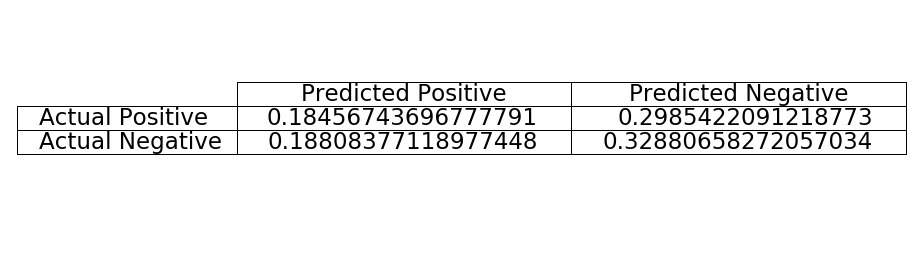

In [125]:
ConfusionMatrix.concat(iterator=final_cm.values()).plot()

ConnectionStrengthClassifier(base_estimator=BaggingClassifier(base_estimator=LogisticRegression(C=5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=5, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_s...n_estimators=30, n_jobs=4, oob_score=False,
         random_state=None, verbose=0, warm_start=False),
               base_strength=0.063, combined_weight=0.1, threshold=0.15)
Accuracy: 0.5133702526839174


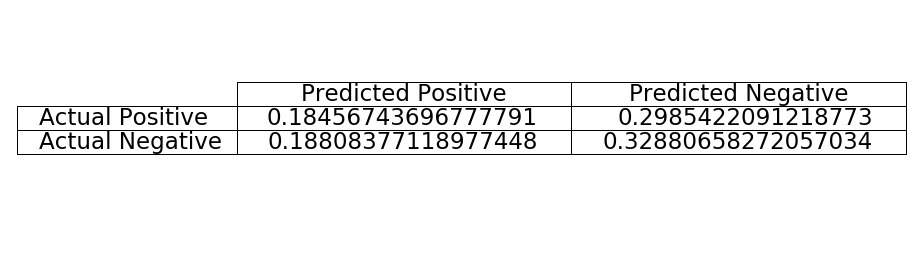

In [126]:
from sklearn.ensemble import AdaBoostClassifier
adaboost_model = AdaBoostClassifier(base_estimator=model)
ada_cm = run_model(adaboost_model)
ConfusionMatrix.concat(iterator=final_cm.values()).plot()

In [127]:
# overfitting
from sklearn.metrics import accuracy_score
sct_model = Classifiers.classifiers.ConnectionStrengthClassifier(threshold=0.15, base_strength=0.063, combined_weight=0.1, 
                                                                   base_estimator=model)
for (d,c),s,cols in zip(stocks, strengths, connections_cols):
    sct_model.fit(d,c, cols, s)
    print(accuracy_score(c, sct_model.predict(d)))

0.540860488798
0.551892551893
0.534784464362
0.569637883008
0.533850931677


In [129]:
# overfitting
from sklearn.metrics import accuracy_score
bmodel = BaggingClassifier(max_samples=0.9, max_features=1.0, n_estimators=30, base_estimator=model, n_jobs=7)
for (d,c),s,cols in zip(stocks, strengths, connections_cols):
    bmodel.fit(d,c)
    print(accuracy_score(c, bmodel.predict(d)))

0.556135437882
0.628815628816
0.553137003841
0.633704735376
0.554037267081
